# PyMC3 v3.10.0
- How to set up a custom likelihood function for two variables   
https://discourse.pymc.io/t/how-to-set-up-a-custom-likelihood-function-for-two-variables/906

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context="paper" , style ="whitegrid",rc={"figure.facecolor":"white"})

import statsmodels.api as sm
import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.10.0


In [2]:

EPS = np.finfo(float).eps
def logiFunc(x):
    v = 1./(1. + tt.exp(-x) )
    v = tt.clip(v,EPS,1-EPS)
    return(v)
 
def pred(X,w):
    linear = tt.sum(w*X,axis=1)
    y =  logiFunc(linear)  
    return(y)

def logLikelihood(t,X,w):
    y = pred(X,w) 
    ll = t * tt.log(y) + (1-t)*tt.log(1-y) 
    ll = tt.sum(ll)
    return(ll)

class Wrapper():
    def __init__(self, t, X):
        self.t = t 
        self.X = X 

    def log_likelihood(self,w):
        return(logLikelihood(self.t, self.X, w))

In [3]:
# data preparation 
df = sm.datasets.anes96.load_pandas().data
exog = ["TVnews","selfLR","PID","educ"]
endog = "vote"

# set data 
m = len(exog)
x = df[exog].values
y = df[endog].values
#x_shared = theano.shared(x)
# sampling parameters 

wrap = Wrapper(y,x)

nIter = 500
with pm.Model() as model2:
    coeff = pm.Normal('beta', mu=0, sigma=100,shape=m)
    pm.Potential('likelihood',logLikelihood(y,x,coeff) )
    #pm.DensityDist('likelihood',wrap.log_likelihood, observed=dict(w=coeff) )

    # fit the model
    trace2 = pm.sample(draws=nIter, cores=4, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 7 seconds.


In [4]:
pm.summary(trace2,credible_interval="beta").round(3)

/opt/conda/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.111,0.036,-0.178,-0.041,0.001,0.001,1377.0,1308.0,1389.0,1294.0,1.0
beta[1],-0.311,0.070,-0.439,-0.176,0.002,0.002,1065.0,1033.0,1066.0,1118.0,1.0
beta[2],1.176,0.070,1.049,1.311,0.002,0.002,1021.0,1021.0,1017.0,1045.0,1.0
beta[3],-0.448,0.050,-0.540,-0.353,0.002,0.001,1081.0,1081.0,1091.0,958.0,1.0


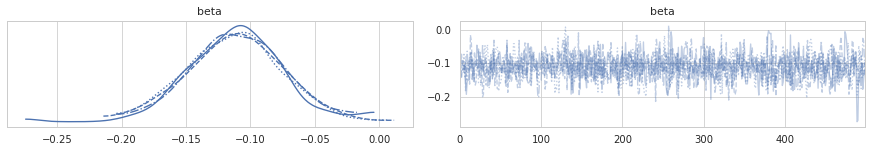

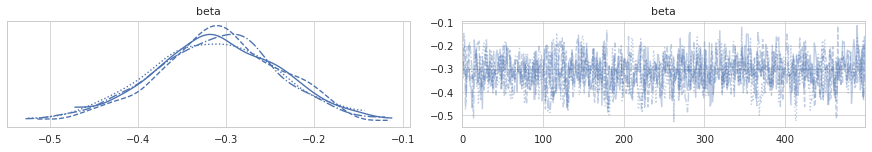

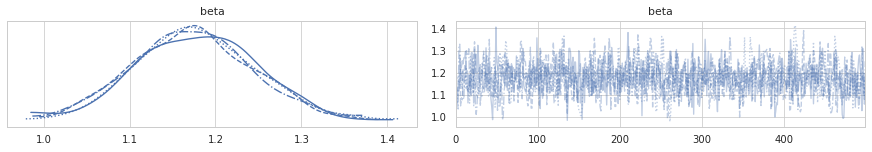

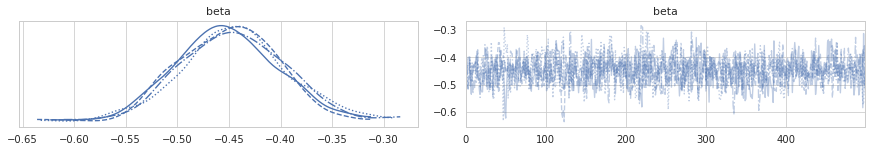

In [5]:
for i in range(4):
    az.plot_trace(trace2, var_names="beta", coords={"beta_dim_0":[i]})

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

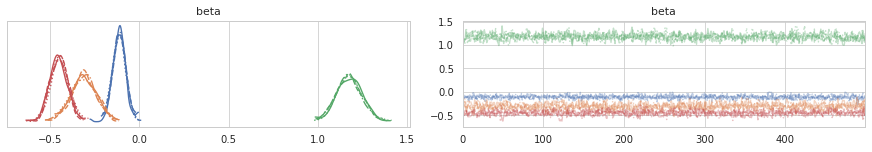

In [6]:
az.plot_trace(trace2, var_names="beta")

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

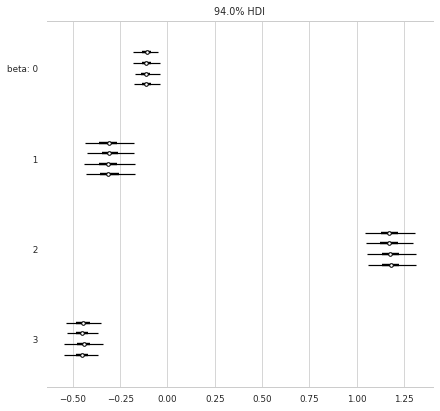

In [7]:
az.plot_forest(trace2, 
               var_names="beta",
               colors='black',
              )

array([[<AxesSubplot:ylabel='beta\n1'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='beta\n0', ylabel='beta\n2'>,
        <AxesSubplot:xlabel='beta\n1'>]], dtype=object)

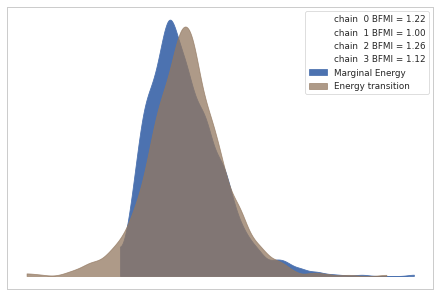

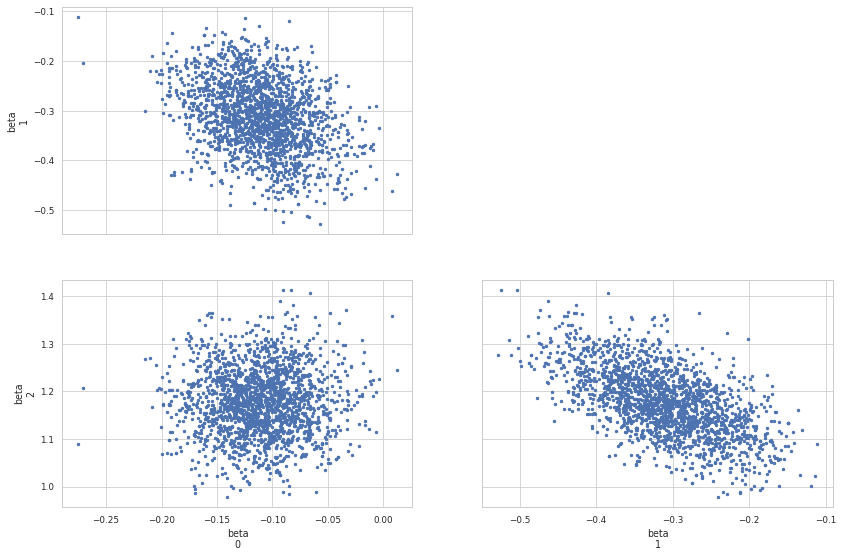

In [8]:
pm.energyplot(trace2)
pm.pairplot(trace2, var_names=["beta"],coords={"beta_dim_0":[0,1,2]}, divergences=True,)

In [18]:
#az.loo(trace2, model2)

# Poisson regression with two outcomes.


In [28]:
yobs1 = [1,2,3,4,5, 3, 3]
yobs2 = [1,2,3,4,5, 10,11,12,13,14,15]
with pm.Model() as model:
    mu = pm.HalfNormal("mu", 100, shape=2)
    L1 = pm.Poisson("Y1", mu=mu[0], observed=yobs)
    L2 = pm.Poisson("Y2", mu=mu[1], observed=yobs2)
    data = pm.sample(1000, tune=100, cores=2, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.9077929015806054, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9293556055942279, but should be close to 0.8. Try to increase the number of tuning steps.


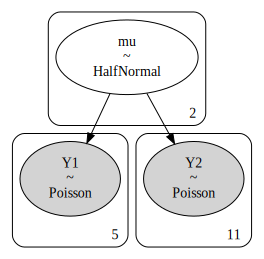

In [29]:
pm.model_to_graphviz(model)

In [30]:
az.summary(data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],3.156,0.815,1.695,4.650,0.030,0.021,740.0,740.0,723.0,836.0,1.0
mu[1],8.286,0.862,6.676,9.881,0.021,0.015,1685.0,1659.0,1693.0,1537.0,1.0
